In [ ]:
from torch.utils.data import DataLoader
from torch import optim

from src.datasets import prepare_datasets
from src.models import CatDogYOLOv1, CatDogYOLOv1ResBB, CatDogYOLOv1Improved
from src.augmentations import Augmentations, RandomBrightness, RandomSaturation, RandomScale, RandomTranslate, Resize

from utils.plots import visualize_batch, plot_mAPs, plot_train_metrics, plot_predictions, plot_confusion_matrix
from utils.trainers import train_model
from utils.trackers import process_video


/Users/karolrogozinski/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/karolrogozinski/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <505BFA5F-B0DD-3186-AD73-BD50DF899AB5> /Users/karolrogozinski/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <709C1DF5-D253-3C66-87E2-C99FD3A259DF> /Users/karolrogozinski/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


## Config

In [2]:
TARGET_IMAGE_SIZE = 112
IMG_DIR = "data/images"
ANNOTATION_DIR = 'data/annotations'

BATCH_SIZE = 16
GRID_SIZE = 7
EPOCHS = 250
PRINT_EVERY = 50
LR = 1e-4


## Data Preparation

In [3]:
transform_train = Augmentations([
    Resize((TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)),
    RandomBrightness(exposure_factor=3),
    RandomSaturation(saturation_factor=3),
    RandomScale(scale_range=(0.8, 1.2)),
    RandomTranslate(translate_range=(-0.2, 0.2)),
])

transform_test = Augmentations([
    Resize((TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE)),
])

device = 'cpu'


In [4]:
from src.datasets import CatDogDataset
dataset = CatDogDataset(img_dir=IMG_DIR, ann_dir=ANNOTATION_DIR,
                        target_image_size=TARGET_IMAGE_SIZE, transform=transform_test)


In [5]:
train_dataset, valid_dataset, test_dataset = prepare_datasets(IMG_DIR, ANNOTATION_DIR, TARGET_IMAGE_SIZE, transform_train, transform_test)

print('Train size:', len(train_dataset))
print('Valid size:', len(valid_dataset))
print('Test size:', len(test_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Train size: 2400
Valid size: 600
Test size: 686


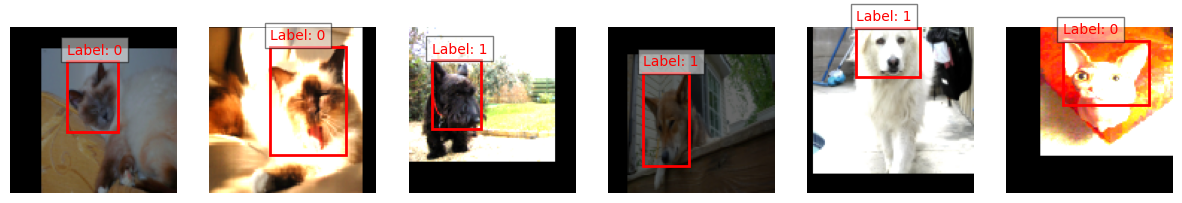

In [6]:
visualize_batch(train_dataloader, 6)


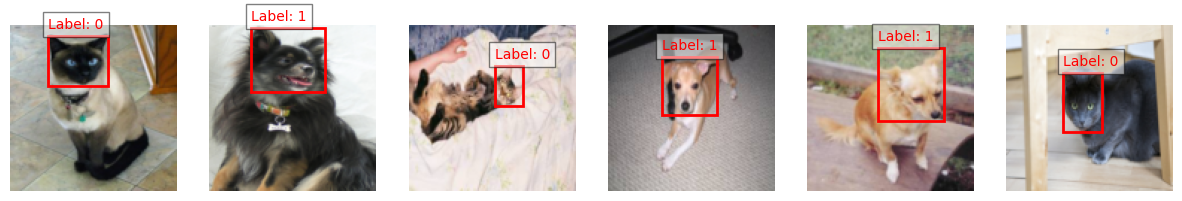

In [7]:
visualize_batch(valid_dataloader, 6)


## Models training

### Basic YOLOv1

 20%|██        | 50/250 [30:34<2:05:37, 37.69s/it]

EPOCH: 50, TRAIN ACC@50: 0.3099, TRAIN LOSS: 1.3472, VAL ACC@50: 0.3045, VAL LOSS: 1.2883


 40%|████      | 100/250 [1:02:07<1:34:21, 37.75s/it]

EPOCH: 100, TRAIN ACC@50: 0.4058, TRAIN LOSS: 1.1175, VAL ACC@50: 0.4139, VAL LOSS: 1.0867


 60%|██████    | 150/250 [1:33:32<1:00:04, 36.04s/it]

EPOCH: 150, TRAIN ACC@50: 0.4392, TRAIN LOSS: 0.9977, VAL ACC@50: 0.4475, VAL LOSS: 1.0042


 80%|████████  | 200/250 [2:04:22<31:08, 37.37s/it]  

EPOCH: 200, TRAIN ACC@50: 0.4911, TRAIN LOSS: 0.9008, VAL ACC@50: 0.4514, VAL LOSS: 0.9513


100%|██████████| 250/250 [2:35:29<00:00, 37.32s/it]

EPOCH: 250, TRAIN ACC@50: 0.5040, TRAIN LOSS: 0.8595, VAL ACC@50: 0.4714, VAL LOSS: 0.9408


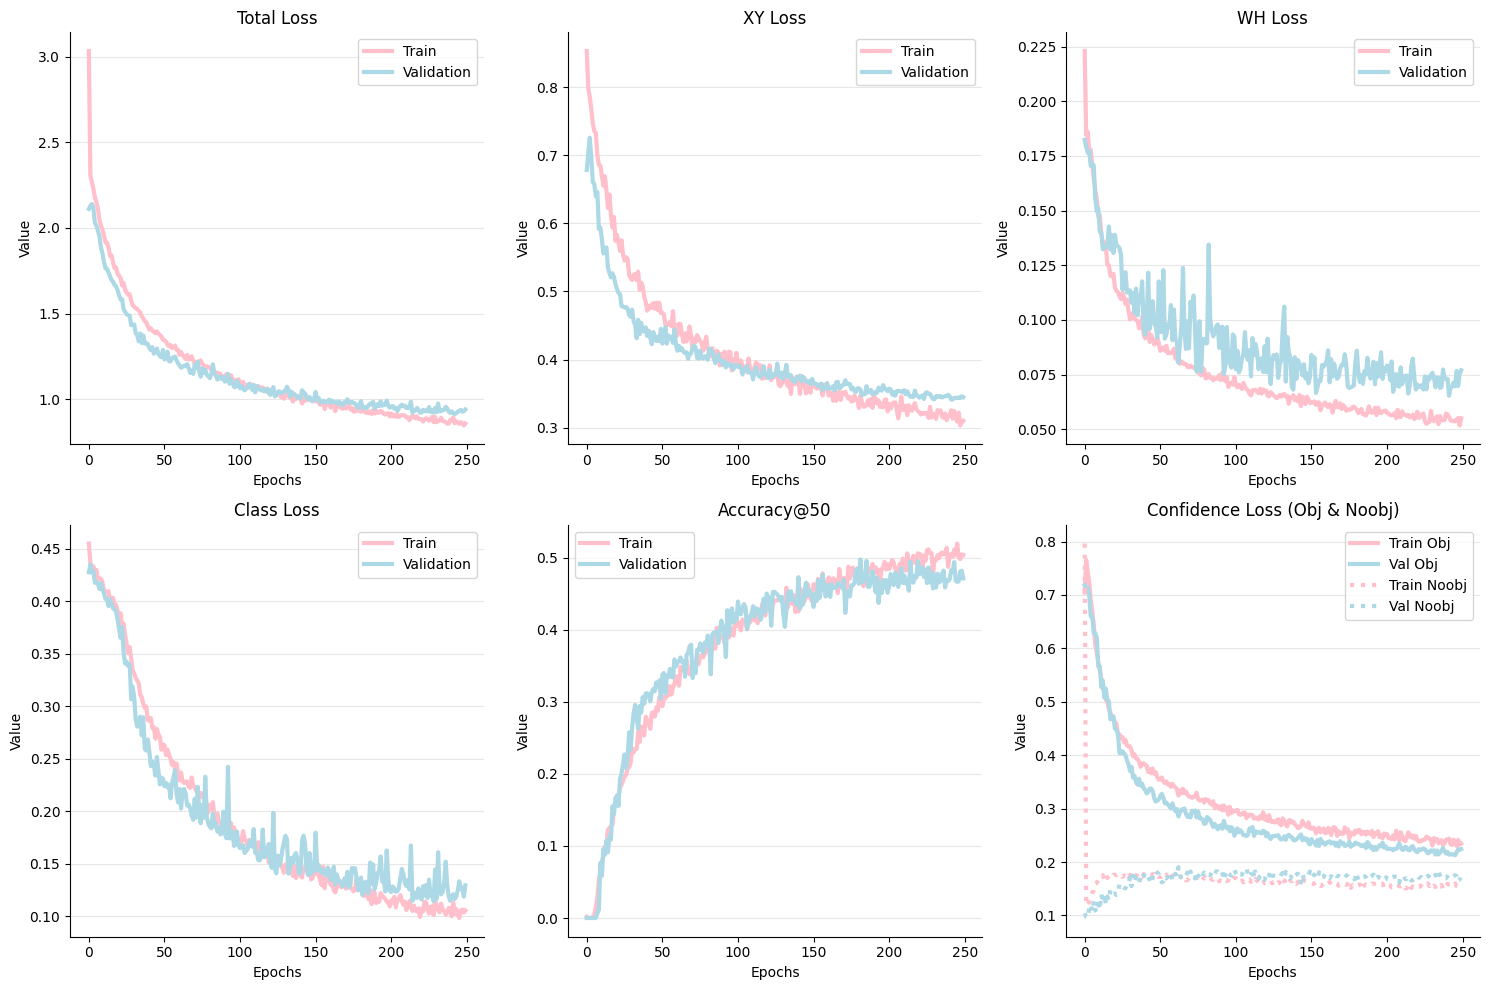

In [8]:
model = CatDogYOLOv1()

optimizer = optim.Adam(model.parameters(), lr=LR)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

train_metrics = train_model(model, optimizer, lr_scheduler, train_dataloader, valid_dataloader, EPOCHS, BATCH_SIZE, plot_every=PRINT_EVERY, patience=EPOCHS)
plot_train_metrics(*train_metrics)


### Improved YOLOv1

 20%|██        | 50/250 [32:33<2:11:28, 39.44s/it]

EPOCH: 50, TRAIN ACC@50: 0.2855, TRAIN LOSS: 1.3707, VAL ACC@50: 0.3277, VAL LOSS: 1.2367


 40%|████      | 100/250 [1:05:05<1:36:43, 38.69s/it]

EPOCH: 100, TRAIN ACC@50: 0.4037, TRAIN LOSS: 1.0676, VAL ACC@50: 0.4519, VAL LOSS: 1.0151


 60%|██████    | 150/250 [1:37:16<1:03:51, 38.32s/it]

EPOCH: 150, TRAIN ACC@50: 0.4726, TRAIN LOSS: 0.9125, VAL ACC@50: 0.4749, VAL LOSS: 0.9475


 80%|████████  | 200/250 [2:09:21<32:02, 38.45s/it]  

EPOCH: 200, TRAIN ACC@50: 0.5020, TRAIN LOSS: 0.8351, VAL ACC@50: 0.5099, VAL LOSS: 0.8982


100%|██████████| 250/250 [2:41:31<00:00, 38.77s/it]

EPOCH: 250, TRAIN ACC@50: 0.5247, TRAIN LOSS: 0.7727, VAL ACC@50: 0.5271, VAL LOSS: 0.8900


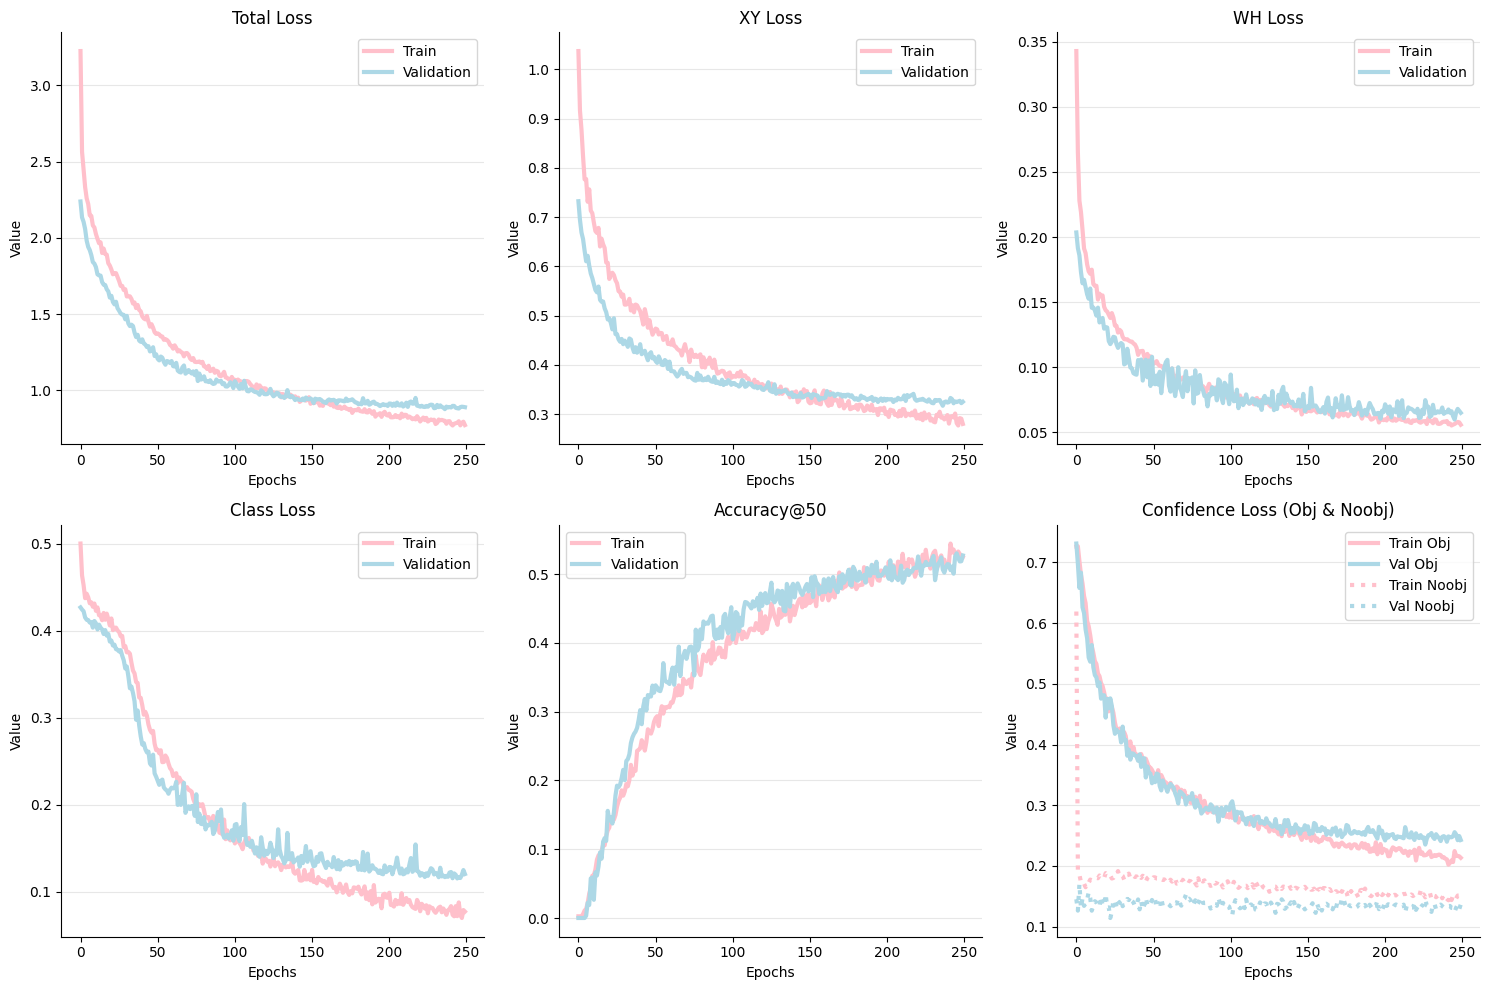

In [9]:
model_i = CatDogYOLOv1Improved()

optimizer_i = optim.Adam(model_i.parameters(), lr=LR)
lr_scheduler_i = optim.lr_scheduler.StepLR(optimizer_i, step_size=20, gamma=0.9)

train_metrics_i = train_model(model_i, optimizer_i, lr_scheduler_i, train_dataloader, valid_dataloader, EPOCHS, BATCH_SIZE, plot_every=PRINT_EVERY, patience=EPOCHS)
plot_train_metrics(*train_metrics_i)


### YOLOv1 with ResNet18 Backbone

 20%|██        | 50/250 [54:31<3:35:30, 64.65s/it]

EPOCH: 50, TRAIN ACC@50: 0.3930, TRAIN LOSS: 1.1350, VAL ACC@50: 0.5131, VAL LOSS: 0.9290


 40%|████      | 100/250 [1:48:47<2:41:45, 64.70s/it]

EPOCH: 100, TRAIN ACC@50: 0.4698, TRAIN LOSS: 0.8786, VAL ACC@50: 0.4874, VAL LOSS: 0.8978


 60%|██████    | 150/250 [2:43:03<1:47:46, 64.67s/it]

EPOCH: 150, TRAIN ACC@50: 0.5165, TRAIN LOSS: 0.7727, VAL ACC@50: 0.5573, VAL LOSS: 0.8884


 80%|████████  | 200/250 [3:37:39<53:55, 64.70s/it]  

EPOCH: 200, TRAIN ACC@50: 0.5457, TRAIN LOSS: 0.6992, VAL ACC@50: 0.5254, VAL LOSS: 0.8953


100%|██████████| 250/250 [4:32:22<00:00, 65.37s/it]

EPOCH: 250, TRAIN ACC@50: 0.5675, TRAIN LOSS: 0.6541, VAL ACC@50: 0.5480, VAL LOSS: 0.8704


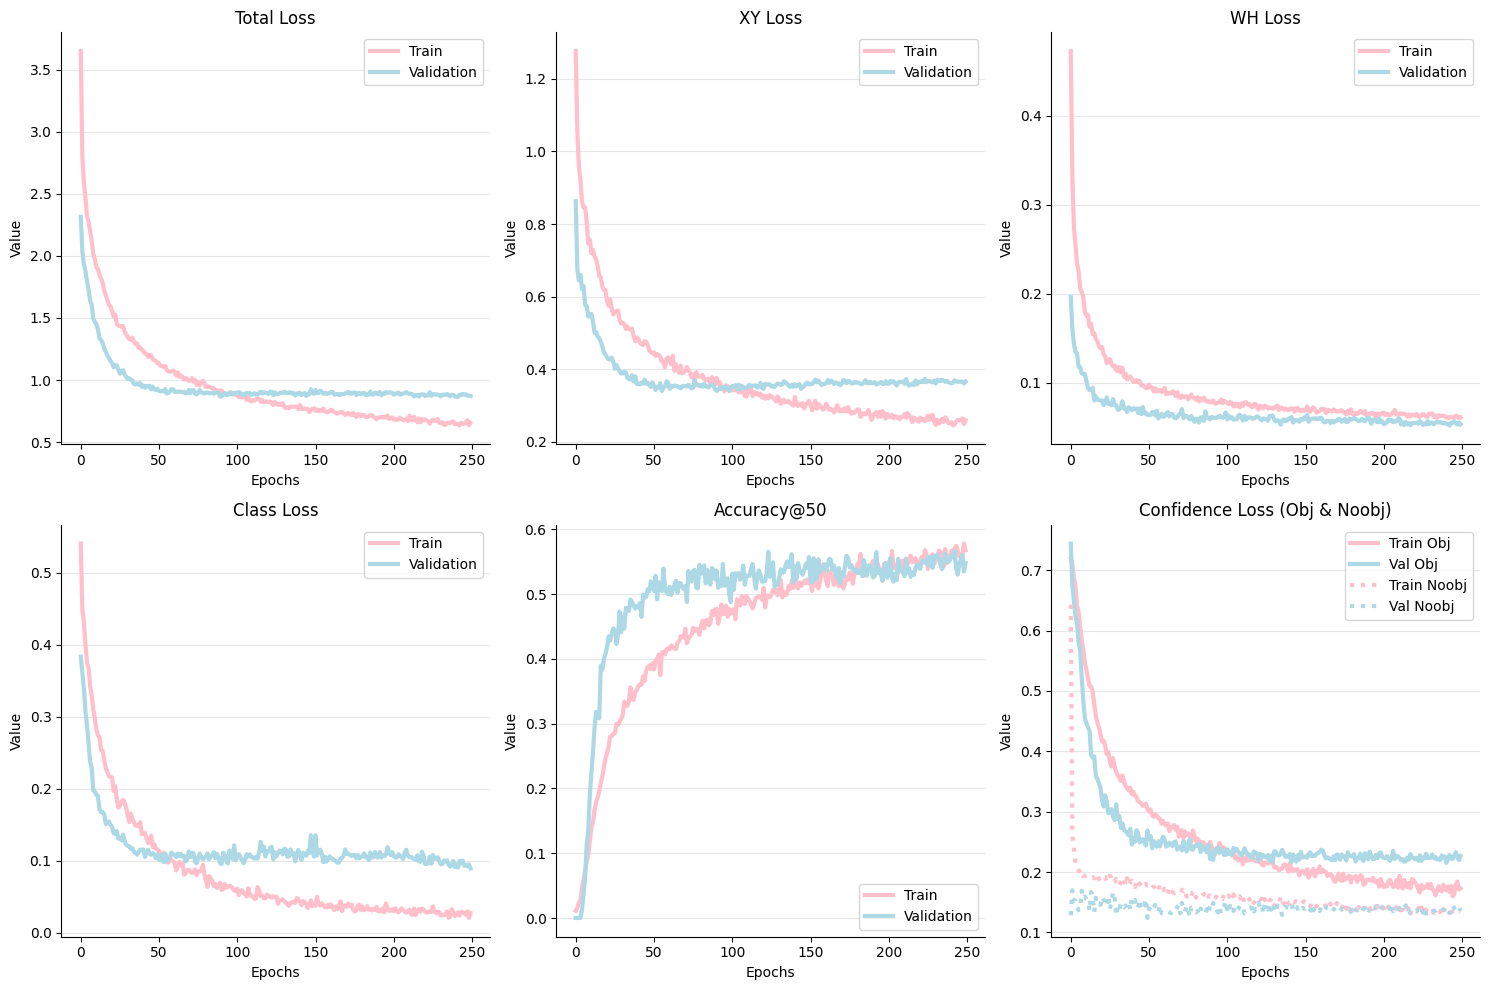

In [26]:
model_bb = CatDogYOLOv1ResBB(hot_layers=10)

optimizer_bb = optim.Adam(model_bb.parameters(), lr=LR)
lr_scheduler_bb = optim.lr_scheduler.StepLR(optimizer_bb, step_size=20, gamma=0.9)

train_metrics_bb = train_model(model_bb, optimizer_bb, lr_scheduler_bb, train_dataloader, valid_dataloader, EPOCHS, BATCH_SIZE, plot_every=PRINT_EVERY, patience=EPOCHS)
plot_train_metrics(*train_metrics_bb)


## Evaluations


### Basic YOLOv1

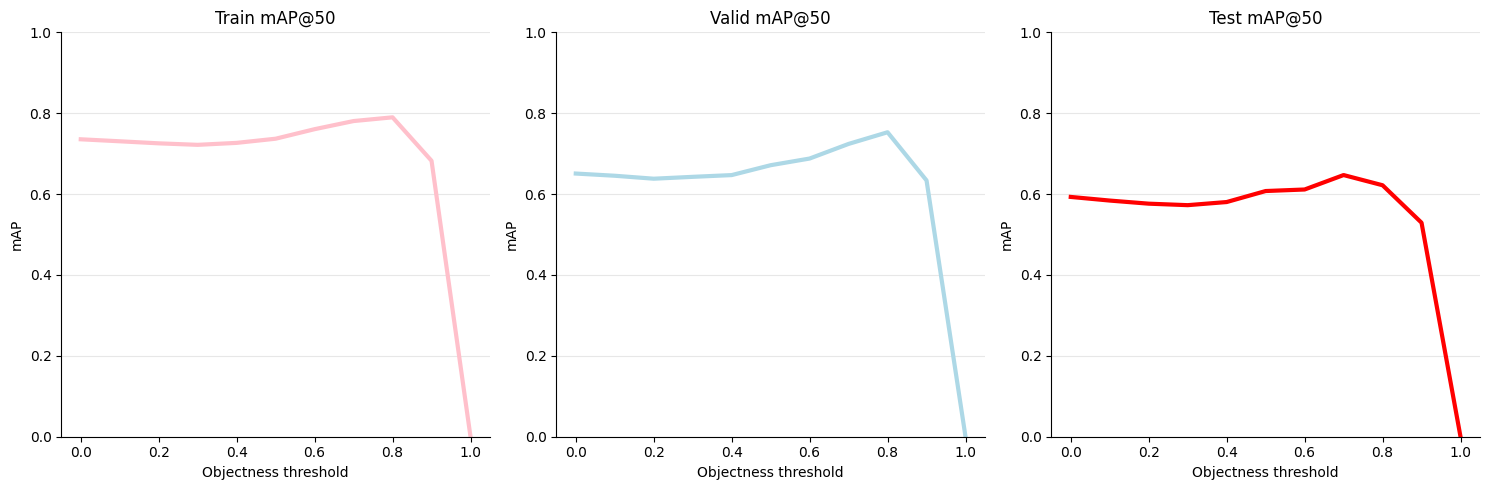

In [11]:
obj_th = plot_mAPs(model, train_dataloader, valid_dataloader, test_dataloader)


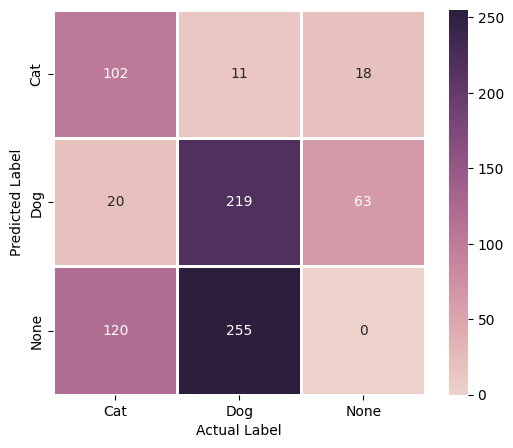

In [12]:
plot_confusion_matrix(model, test_dataloader, obj_th)


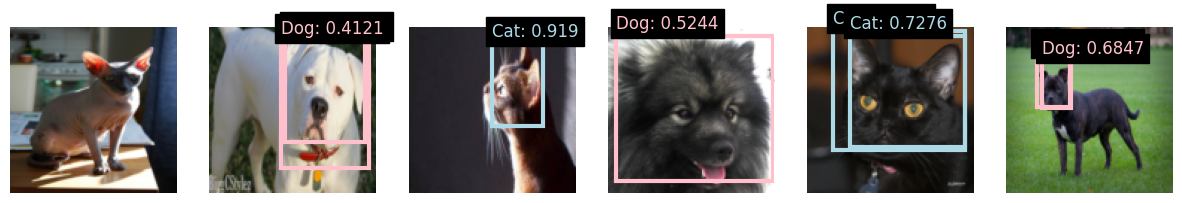

In [318]:
plot_predictions(model, test_dataloader, obj_th/2)


### Improved YOLOv1


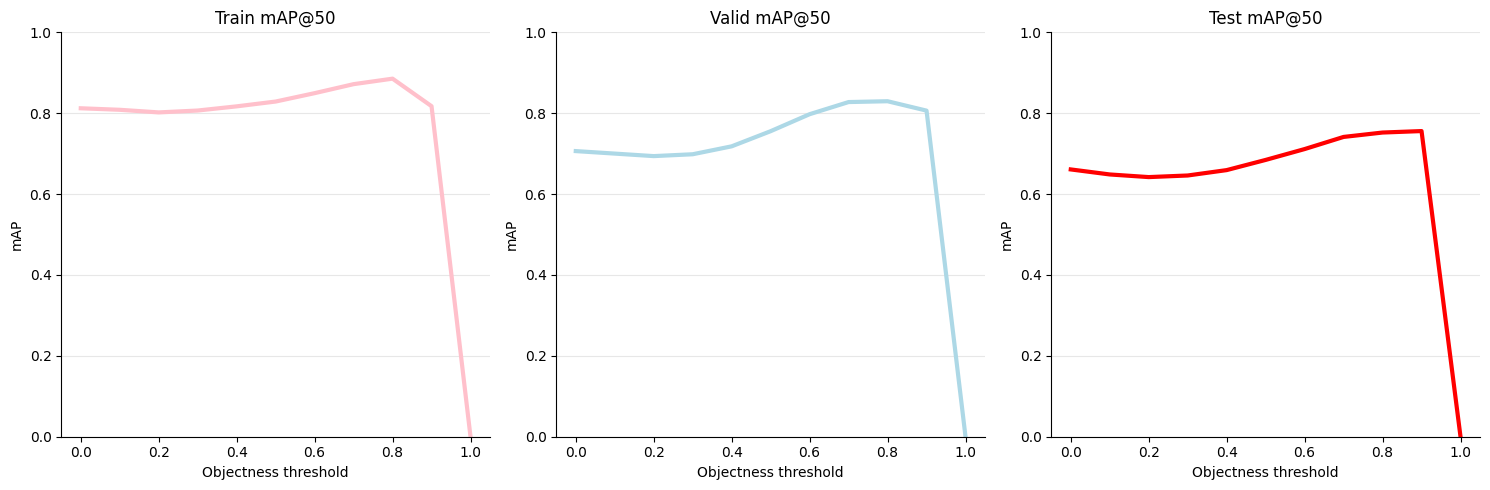

In [14]:
obj_th_i = plot_mAPs(model_i, train_dataloader, valid_dataloader, test_dataloader)

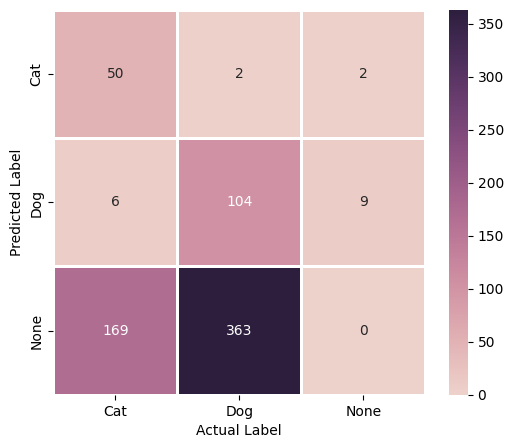

In [25]:
plot_confusion_matrix(model_i, test_dataloader, obj_th_i)


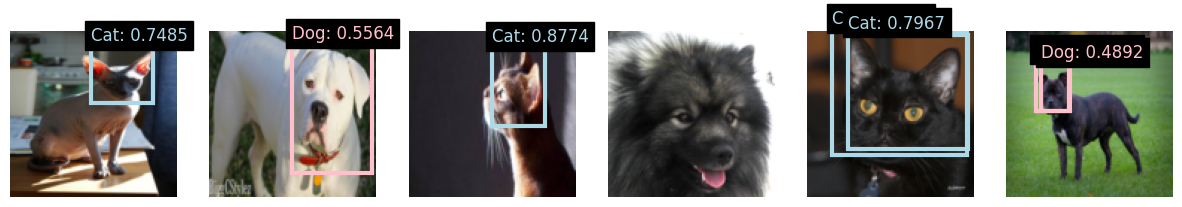

In [316]:
plot_predictions(model_i, test_dataloader, obj_th_i/2)


### YOLOv1 with ResNet18 Backbone

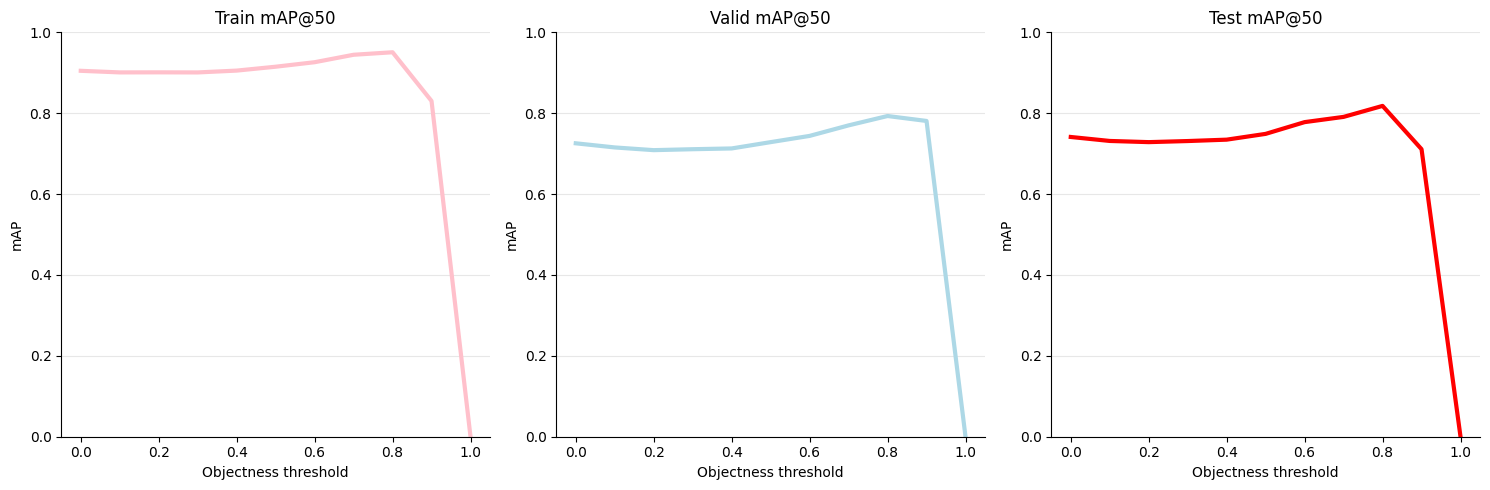

In [27]:
obj_th_bb = plot_mAPs(model_bb, train_dataloader, valid_dataloader, test_dataloader)


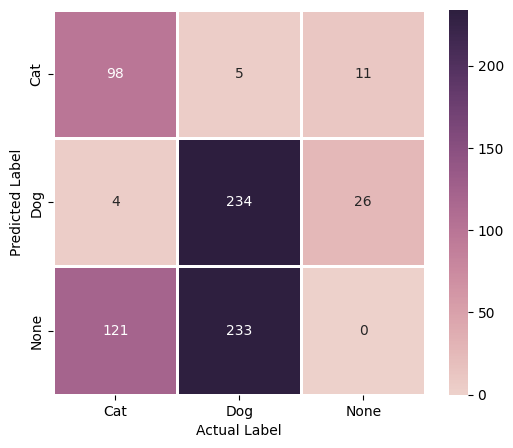

In [28]:
plot_confusion_matrix(model_bb, test_dataloader, obj_th_bb)

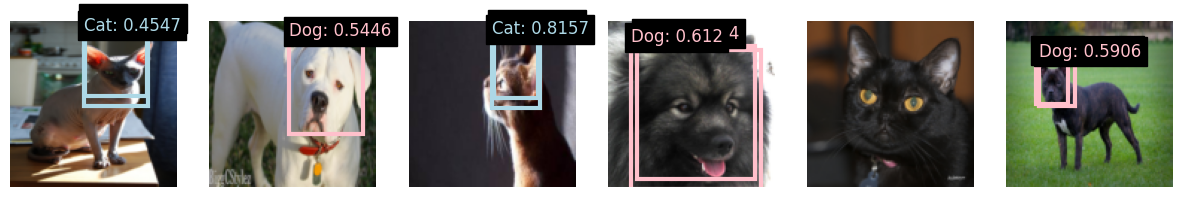

In [319]:
plot_predictions(model_bb, test_dataloader, obj_th_bb/2)


### Live predictions on video

In [ ]:
process_video(model_bb, obj_th_bb/2, input_video_path='./data/videos/cats_dogs_1.mov')
